## 24.5.1 Generating Sequenced Data

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def sum_of_sines(size, d_theta, skip_steps, freqs, amps, phases):
    '''Add together multiple sine waves
    Params
    ------
    size: list of generate data
    d_theta: step in radian between samples
    skip_steps: determines the start of the sequence
    freq, amps and phases shold be all at same lenght
    
    Return
    ------
    numpy array
    '''
    steps = np.array(range(size))
    angles = (d_theta * (steps + skip_steps)).reshape((-1, 1))
    amps, freqs, phases = np.array([amps] * size), np.array([freqs] * size), np.array([phases] * size)
    
    y = amps * np.sin(freqs * (phases + angles))

    return np.sum(y, axis=1)
    

In [97]:
train_seq1 = sum_of_sines(200, .057, 0, [1,2], [1,2], [0,0])
test_seq1 = sum_of_sines(200, .057, 400, [1,2], [1,2], [0,0])

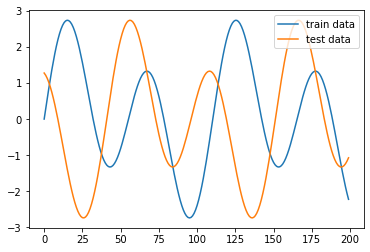

In [102]:
plt.title('Generate Dataset Sequence 1')
plt.plot(train_seq1, label='train data')
plt.plot(test_seq1, label='test data')
plt.legend(loc='upper right')

In [103]:
train_seq2 = sum_of_sines(200, .057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])
test_seq2 = sum_of_sines(200, .057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

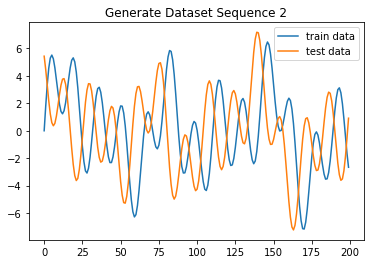

In [104]:
plt.title('Generate Dataset Sequence 2')
plt.plot(train_seq2, label='train data')
plt.plot(test_seq2, label='test data')
plt.legend(loc='upper right')

In [105]:
from sklearn.preprocessing import MinMaxScaler

In [106]:
train_sequence = train_seq1.reshape((-1, 1))
test_sequence = test_seq1.reshape((-1, 1))

scaler = MinMaxScaler()
scaler.fit(train_sequence)
scaled_train_sequence = scaler.transform(train_sequence)
scaled_test_sequence = scaler.transform(test_sequence)

In [357]:
from numpy.lib.stride_tricks import as_strided

def samples_targets(seq, window, step_size):
    """rolling window implementation using stride tricks"""
    row_stride = seq.itemsize * step_size
    col_stride = seq.itemsize
    # leave last item to be a target add +1 to go with the slide window up to end
    num_frames = (len(seq) - window) // step_size
    # output shape
    shape = (num_frames, window, 1)
    # strides: how to move the pointer to next item shape (s, n, m)
    strides = (row_stride, col_stride, col_stride)
    
    samples = as_strided(seq, shape=shape, strides=strides)
    targets = seq[window::step_size]
    
    return samples, targets.flatten()

In [358]:
window_size = 10
step = 1
X_train, y_train = samples_targets(scaled_train_sequence, window_size, step)
X_test, y_test = samples_targets(scaled_test_sequence, window_size, step)

In [361]:
print(X_train.shape, y_train.shape)

(190, 10, 1) (190,)


In [380]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# test if the GPU is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [364]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
190/190 [==============================] - 5s 27ms/step - loss: 0.2590
Epoch 2/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0605
Epoch 3/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0457
Epoch 4/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0335
Epoch 5/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0254
Epoch 6/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0192
Epoch 7/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0160
Epoch 8/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0144
Epoch 9/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0132
Epoch 10/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0125
Epoch 11/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0120
Epoch 12/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0112
E

190/190 [==============================] - 4s 23ms/step - loss: 3.5394e-05
Epoch 96/100
190/190 [==============================] - 4s 23ms/step - loss: 3.9844e-05
Epoch 97/100
190/190 [==============================] - 4s 23ms/step - loss: 3.6363e-05
Epoch 98/100
190/190 [==============================] - 4s 23ms/step - loss: 3.9719e-05
Epoch 99/100
190/190 [==============================] - 4s 23ms/step - loss: 3.1652e-05
Epoch 100/100
190/190 [==============================] - 4s 23ms/step - loss: 3.7777e-05


In [365]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [373]:
# inverse-tranform original targets
inverse_y_train = scaler.inverse_transform(y_train.reshape((-1, 1)))
inverse_y_test = scaler.inverse_transform(y_test.reshape((-1, 1)))

# inverse-transform predictions
inverse_y_train_predict = scaler.inverse_transform(y_train_predict.reshape((-1, 1)))
inverse_y_test_predict = scaler.inverse_transform(y_test_predict.reshape((-1, 1)))

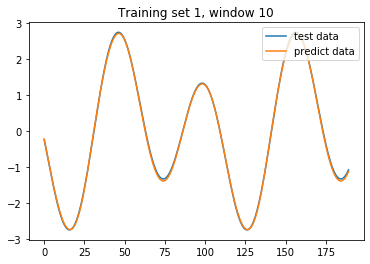

In [374]:
plt.title('Training set 1, window 10')
plt.plot(inverse_y_test, label='test data')
plt.plot(inverse_y_test_predict, label='predict data')
plt.legend(loc='upper right')

Text(0, 0.5, 'loss')

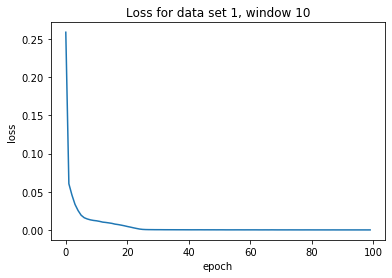

In [379]:
loss = history.history['loss']
epoch = history.epoch
plt.title('Loss for data set 1, window 10')
plt.plot(epoch, loss)
plt.xlabel('epoch')
plt.ylabel('loss')

## Running for data set 2

In [381]:
train_sequence = train_seq2.reshape((-1, 1))
test_sequence = test_seq2.reshape((-1, 1))

scaler = MinMaxScaler()
scaler.fit(train_sequence)
scaled_train_sequence = scaler.transform(train_sequence)
scaled_test_sequence = scaler.transform(test_sequence)

In [382]:
window_size = 10
step = 1
X_train, y_train = samples_targets(scaled_train_sequence, window_size, step)
X_test, y_test = samples_targets(scaled_test_sequence, window_size, step)

In [397]:
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, batch_size=16)

Epoch 1/200
190/190 [==============================] - 2s 11ms/step - loss: 0.1603 - mean_absolute_error: 0.3588
Epoch 2/200
190/190 [==============================] - 0s 1ms/step - loss: 0.1310 - mean_absolute_error: 0.3195
Epoch 3/200
190/190 [==============================] - 0s 1ms/step - loss: 0.1048 - mean_absolute_error: 0.2794
Epoch 4/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0813 - mean_absolute_error: 0.2397
Epoch 5/200
190/190 [==============================] - 0s 2ms/step - loss: 0.0624 - mean_absolute_error: 0.2042
Epoch 6/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_absolute_error: 0.1798
Epoch 7/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0395 - mean_absolute_error: 0.1627
Epoch 8/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0344 - mean_absolute_error: 0.1534
Epoch 9/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0325 - mean_absolute_error

190/190 [==============================] - 0s 1ms/step - loss: 0.0182 - mean_absolute_error: 0.1150
Epoch 74/200
190/190 [==============================] - 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.1142
Epoch 75/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0178 - mean_absolute_error: 0.1137
Epoch 76/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.1129
Epoch 77/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.1124
Epoch 78/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0172 - mean_absolute_error: 0.1118
Epoch 79/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0170 - mean_absolute_error: 0.1111
Epoch 80/200
190/190 [==============================] - 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.1108
Epoch 81/200
190/190 [==============================] - 0s 2ms/step - loss: 0.0167 - mean_absolute_error: 0.1

190/190 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0730
Epoch 146/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0723
Epoch 147/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0717
Epoch 148/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0711
Epoch 149/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0706
Epoch 150/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0701
Epoch 151/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0696
Epoch 152/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0691
Epoch 153/200
190/190 [==============================] - 0s 1ms/step - loss: 0.0063 - mean_absolute_er

Text(0, 0.5, 'loss')

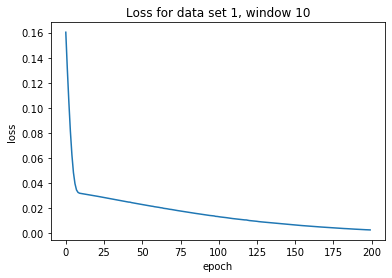

In [398]:
loss = history.history['loss']
epoch = history.epoch
plt.title('Loss for data set 1, window 10')
plt.plot(epoch, loss)
plt.xlabel('epoch')
plt.ylabel('loss')

In [399]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [400]:
# inverse-tranform original targets
inverse_y_train = scaler.inverse_transform(y_train.reshape((-1, 1)))
inverse_y_test = scaler.inverse_transform(y_test.reshape((-1, 1)))

# inverse-transform predictions
inverse_y_train_predict = scaler.inverse_transform(y_train_predict.reshape((-1, 1)))
inverse_y_test_predict = scaler.inverse_transform(y_test_predict.reshape((-1, 1)))

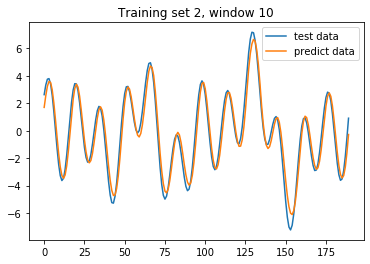

In [401]:
plt.title('Training set 2, window 10')
plt.plot(inverse_y_test, label='test data')
plt.plot(inverse_y_test_predict, label='predict data')
plt.legend(loc='upper right')